# Preliminary

In [32]:
import numpy as np
import pandas as pd
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import sys
BASE_PATH = os.path.realpath('..')
DATASETS_DIR = os.path.join(BASE_PATH, 'datasets')
LIB_DIR = os.path.join(BASE_PATH,'lib')
if LIB_DIR not in sys.path:
    sys.path.append(LIB_DIR)

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

from importlib import reload

In [2]:
bank_ds = pd.read_csv(os.path.join(DATASETS_DIR, 'bank.csv'), sep=';')
print(bank_ds.shape)
bank_ds.head()

(4521, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [3]:
y_feat = 'y'
s = bank_ds.drop(y_feat,1).dtypes
cat_feats = list(s[s==np.dtype('O')].index)
real_feats = list(s.drop(cat_feats).index)

X_train, X_test, y_train, y_test = train_test_split(bank_ds[cat_feats+real_feats], bank_ds[y_feat].apply(lambda x: {'no':0,'yes':1}[x]))

train_pool = cb.Pool(X_train, y_train, cat_features=cat_feats)
test_pool = cb.Pool(X_test, y_test, cat_features=cat_feats)
bb = cb.CatBoostClassifier()
bb.fit(train_pool, verbose=False, plot=False)

train_preds, test_preds = bb.predict(train_pool), bb.predict(test_pool)
train_preds_proba, test_preds_proba = bb.predict_proba(train_pool)[:,1], bb.predict_proba(test_pool)[:,1]
metrics_ds = []
for m in [accuracy_score, precision_score, recall_score]:
    res = {'train':m(y_train, train_preds), 'test':m(y_test, test_preds), 'metrics':m.__name__}
    metrics_ds.append(res)
metrics_ds.append({'train':y_train.mean(), 'test':y_test.mean(), 'metrics':'y_mean'})
metrics_ds = pd.DataFrame(metrics_ds).reindex(columns=['metrics','train','test'])
metrics_ds

,metrics,train,test
0,accuracy_score,0.938348,0.901857
1,precision_score,0.843137,0.651163
2,recall_score,0.559896,0.408759
3,y_mean,0.113274,0.121132


# First thought on interpretation

## The task

The goal is to identify what features are the most important for the model predictions. I.e. what exact feature changes affect predictions the most. And, if possible, what exact feature _values_ changes affect predictions the most.
The interpretation should somehow use Formal Concept Analysis. As example the result of the interpretation should be presented as a Concept Lattice.

A model to interpret is supposed to be a Black Box, i.e. one knows nothing about its internal structure. The only known things are:
* input data $X$ (the set of features and their values needed for the model to run)
* Black Box model as a function $BB: X \mapsto Y$, where $Y$ is prediction of the model.

## Benefits of FCA

Formal Concept is a mathematical structure though may be useful for business analysis. Some features in the original dataset may correspond to the same business value. To resolve this one can either change the input data and the model (not our case) or somehow consider it at the stage of interpreting the model. The latter can be done with assigning specific values of different features to the same Formal Concept.

## Lack of FCA

FCA is good for interpreting the result though it's not always the best model to predict the result. So consider the given Black Box model is the model possible model to solve the task via some metric. Therefore FCA should be used only to interpret the Black Box rather then predicting its output.

## Ways to interpret

There are 2 basic ways to interpret a model:
1. Global - what features are the most important in the model given data $X$. The outcome is the set of features ordered by their contribution to all the rows of data.
2. Local - what features are the most important in the model for given row (object) $g\in X$. The output is the set of features ordered by their contribution into specific rox $x$ of data. If possible - how exactly did they influence the prediction.

## Ideas of intepretation

### One feature noise
For every feature $f \in F$ ($F$ is the set of all features), change the values of $f$ to some noise and calculate $$\Delta Y_f=\frac{1}{|G|} |\{g\in G| |BB(g_f)-BB(g)|>k\}|  $$, 
where
* $g_f$ - data with nosed feature $f$,
* $g$ - the default data,
* $k$ - some coefficient corresponding to the precision of the interpretation,
* $|*|$ - cardinality of a set

Then construct the context 

### Multiple feature nose

Find every combination of the features that significatly infuence the output

### Using SHAP
https://github.com/slundberg/shap

SHAP is one of the most popular techniques of interpretation. May be we can use it?

#### Shap features importances

#### Shap feature _values_ importances

In [5]:
def predict_with_noise(fs, X, model, cat_feats, random_state=142, predict_proba=False):
    if type(fs)==str:
        fs = [fs]
    for f in fs:
        if f in cat_feats:
            X[f] = np.random.choice(X[f].unique(), size=len(X))
        else:
            X[f] = np.random.uniform(X[f].min(), X[f].max(),size=len(X))
    pool = cb.Pool(X, cat_features=cat_feats)
    preds = model.predict_proba(pool)[:,1] if predict_proba else model.predict(pool)
    return preds

#### 1. How much does it correlate with actual feature importances

Calculate some aggregated statisctics over difference between original and noised predictions

In [6]:
res_ds = []
for f in tqdm_notebook(cat_feats+real_feats):
    for rs in tqdm_notebook(range(100), leave=True, desc=f, disable=True):
        diff = train_preds_proba - predict_with_noise(f, X_train, bb, cat_feats, random_state=rs, predict_proba=True)
        res = {'random_state':rs, 'feature':f, 'dataset':'train',
              'mean_diff':np.abs(diff).mean(), 'median_diff':np.median(np.abs(diff)), 'max_diff':np.abs(diff).max(), 'min_diff':np.abs(diff).min()}
        res_ds.append(res)
        
        diff = test_preds_proba - predict_with_noise(f, X_test, bb, cat_feats, random_state=rs, predict_proba=True)
        res = {'random_state':rs, 'feature':f, 'dataset':'test',
              'mean_diff':np.abs(diff).mean(), 'median_diff':np.median(np.abs(diff)), 'max_diff':np.abs(diff).max(), 'min_diff':np.abs(diff).min()}
        res_ds.append(res)
res_ds = pd.DataFrame(res_ds)
res_ds.head()

,dataset,feature,max_diff,mean_diff,median_diff,min_diff,random_state
0,train,job,0.243570,0.009037,0.001149,0.0,0
1,test,job,0.208085,0.009305,0.001244,0.0,0
2,train,job,0.258275,0.008973,0.001056,0.0,1
3,test,job,0.207539,0.009822,0.001269,0.0,1
4,train,job,0.227068,0.008906,0.000984,0.0,2


Actual feature importances given by Black Box model (CatBoost has implemented feature importances evaluation algorithm)

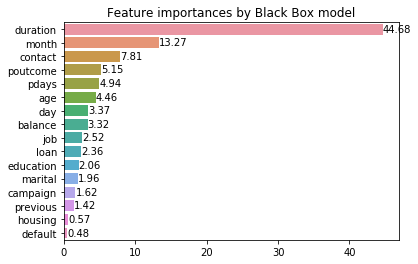

In [20]:
bb_imps = pd.Series(bb.get_feature_importance(type='PredictionValuesChange'), index=bb.feature_names_).sort_values(ascending=False)
bb_imps = bb_imps/bb_imps.sum()*100
sns.barplot(x=bb_imps.values, y=bb_imps.index)
for idx,t in enumerate(bb_imps.iteritems()):
    plt.text(t[1], idx+0.2, f"{t[1]:.2f}")
plt.title('Feature importances by Black Box model')
plt.show()

Calculate Shap Values (one of the most popular interpretation method)

In [8]:
sv = pd.DataFrame(bb.get_feature_importance(data=test_pool, type='ShapValues'), columns=list(test_pool.get_feature_names())+['bias'])
sv.head()

,job,marital,education,default,housing,loan,contact,month,poutcome,age,balance,day,duration,campaign,pdays,previous,bias
0,-0.025554,-0.052483,-0.020864,-0.008272,0.056688,0.071182,0.166023,-0.191343,-0.112816,-0.068299,0.002734,-0.108887,2.743579,-0.007513,-0.016201,-0.021038,-3.537825
1,0.013355,-0.021601,0.069584,0.004032,0.067470,0.092427,0.209978,0.003120,-0.126183,-0.077273,0.001554,0.061769,-1.800560,0.032171,0.000872,-0.017133,-3.537825
2,-0.181284,-0.131565,-0.002421,0.003093,0.067279,0.076578,0.191983,-0.112292,-0.124397,-0.094182,-0.002072,-0.076407,-0.072594,0.033858,0.018755,-0.024502,-3.537825
3,0.008477,-0.036164,0.032721,0.003829,0.067026,0.090101,0.207680,-0.317690,-0.127074,-0.063826,-0.070508,0.061206,-0.777579,0.031565,-0.008815,-0.018897,-3.537825
4,0.169447,0.074013,0.007198,0.003668,0.048131,0.068019,0.518715,1.873482,0.120650,0.071518,0.026068,-0.050045,-1.631519,-0.449493,0.054319,-0.010784,-3.537825


/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




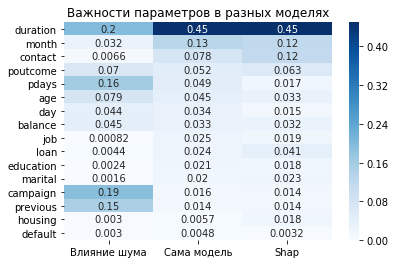

In [112]:
m,af = 'median_diff','max'
cds = res_ds[res_ds['dataset']=='test'].groupby('feature').agg({m:af})
cds = pd.concat([ cds, bb_imps,sv.drop('bias',1).abs().mean(),],1)
cds.columns = [m,'bb','shap']
cds /= cds.sum()
cds = cds.sort_values('bb',ascending=False)
sns.heatmap(cds, cmap='Blues', annot=True)
plt.title('Важности параметров в разных моделях')
plt.xticks([0.5,1.5,2.5], ['Влияние шума','Сама модель','Shap'])
plt.show()

Our method is not perfectly correlated as it's quite simple compared to CatBoost feature importance (which uses internal model structure) and Shap values (which has great game theory background).

#### 2. Try to apply FCA

In [23]:
context = pd.DataFrame(index=X_test.index, columns=X_test.columns)
for f in tqdm_notebook(context.columns):
    context[f] = np.mean(np.abs([test_preds_proba-predict_with_noise(f, X_test, bb, cat_feats, random_state=rs, predict_proba=True) for rs in range(100)]),0)

Firstly, binarize the context into standart Formal Context

/home/egor/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


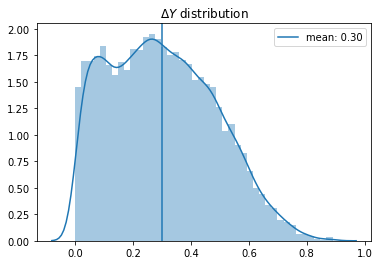

In [26]:
sns.distplot(context.values.flatten())
m = context.values.flatten().mean()
plt.axvline(m, label=f'mean: {m:.2f}')
plt.legend()
plt.title('$\Delta Y$ distribution')
plt.show()

Choose Binarization threshold to 0.41 as it is mean difference of noised and original predictions

In [27]:
thresh = 0.41
context_bin = context.copy()
context_bin[context_bin>=thresh] = 1
context_bin[context_bin<thresh] = 0
context_bin = context_bin.astype(bool)
print(context_bin.shape)
context_bin.head()

(1131, 16)


,job,marital,education,default,housing,loan,contact,month,poutcome,age,balance,day,duration,campaign,pdays,previous
4481,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2310,False,False,True,True,True,True,True,True,False,True,True,True,True,True,True,True
1219,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4095,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
569,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True


In [28]:
import concepts

In [33]:
import fca_interp as fcai

In [75]:
%%time
cntx = fcai.Context(context_bin[:100],y_true=y_test.values[:100], y_pred=test_preds[:100])
fm = fcai.FormalManager(cntx, ds_obj=X_test.iloc[:100], cat_feats=cat_feats,
                        task_type='binary classification')
fm.construct_concepts(use_tqdm=False)
fm.construct_lattice(use_tqdm=False)

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: U

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: U

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: U

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: U

CPU times: user 32.5 s, sys: 74.9 ms, total: 32.6 s
Wall time: 32.5 s


In [76]:
len(fm._concepts)

965

In [74]:
fm.get_concept_by_id(10)._metrics

In [90]:
fig = fm.get_plotly_fig(level_sort='all',
                        sort_by="accuracy",#'precision', "recall"
                        y_precision=2,  title='Bank DS Concept Lattice',
                       color_by='y_pred',)

In [91]:
fig

Изображение можно приближать и отдалять выделяя необходимую зону на экране. На решётке можно три различных измерения:
* положение по вертикали - порядок между концептами
* положение по горизонтали - среднее предсказание для объектов концепта (sort_by="y_pred"), среднее истинное значение $y$ внутри концепта (sort_by="y_true"), значения метрик (в случае бин. классификации -{"accuracy", "precision", "recall"})
* цвет - те же варианты, что и в пункте "положение по горизонтали"

На данный момент график сильно зашумлён - на нём изображенно слишком много кластеров и связей между ними. В дальнейшем надо будет что-то с этим придумать.

Однако, видно, что красные точки (положительные предсказания) как правило появляются в левой половине изображения.

Продолжение анализа...

Проанализируем отдельный концепт (из тех, которые ошибочно перепредсказываются)

In [93]:
fm.get_concept_by_id(787)

Concept 787
extent (len: 6): 3940, 110, 2451, 3182, 3116, 2348
intent (len: 8): job, marital, education, default, housing, loan, poutcome, duration
lower neighbours (len: 3): 888,843,923
upper neighbours (len: 3): 170,620,663
pattern: {'job': {'student': 0.2, 'unknown': 0.2, 'technician': 0.2, 'entrepreneur': 0.2, 'self-employed': 0.2}, 'marital': {'divorced': 0.6, 'single': 0.2, 'married': 0.2}, 'education': {'secondary': 0.4, 'primary': 0.4, 'tertiary': 0.2}, 'default': {'no': 0.6, 'yes': 0.4}, 'housing': {'no': 0.6, 'yes': 0.4}, 'loan': {'no': 0.6, 'yes': 0.4}, 'poutcome': {'success': 0.8, 'other': 0.2}, 'duration': (314.60256552390143, 995.789881798019, 1589.9149872307034)}
level: 8
mean y_true: 0.16666666666666666
mean y_pred: 0.3333333333333333
metrics: {'accuracy': 0.83, 'precision': 0.5, 'recall': 1.0}

На объекты из этого кластера влияют 8 признаков, перечисленных в intent.
* job - распределён достаточно равномерно, но большинство занятий предполагает самозанятость
* marital - большинство разведено, но это не абсолютное большинство. Хотя, можно сказать, что 80% людей в концепте - одиноки.
* education - как правило, выпускники школ
* default - примерно 50/50
* housing - примерно 50/50
* loan - примерно 50/50
* poutcome - предыдущая кампания проходила в основном успешно
* duration - очень долгий разговор (больше 5 минут)

Т.е. людей в этом концепте можно охарактеризовать как "одинокие самозанятые люди без высшего образования, которым интересно было бы открыть вклад, но пока они не готовы (возможно из-за текущих задолженностей")

# Shap

## Бинаризация

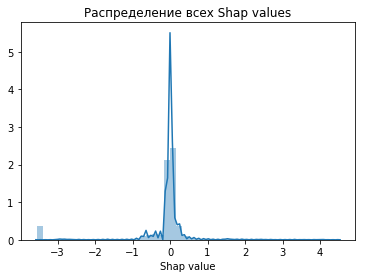

In [121]:
sns.distplot(sv.values.flatten())
plt.title('Распределение всех Shap values')
plt.xlabel('Shap value')
plt.show()

Попробуем бинаризовать значения Shap. Будем считать, что атрибут m "хорошо" влияет на объект g, если соответствующее Shap значение больше 0.75 квантили от всех значений Shap. Аналогично, атрибут m "плохо" влияет на объект g, если соответсвующее Shap значение меньше 0.25 квантили от всех значений Shap.

Так как в этом случае в формальном контекстве получается 16*2=32 признака, а это сильно замедляет расчёт концептов, можно брать лишь самые значимые признаки в модели, благо Shap может их достаточно надёжно отсортировать.

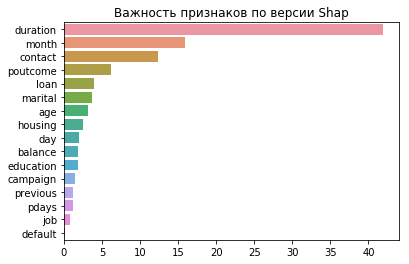

In [154]:
s = sv.abs().median().sort_values(ascending=False).drop('bias')
s = s/s.sum()*100
sns.barplot(x=s.values, y=s.index)
plt.title('Важность признаков по версии Shap')
plt.show()

In [166]:
sv_bin = sv.drop('bias',1)
quant = np.quantile(sv.values.flatten(),[0.25,0.75])
for f in sv_bin.columns:
    if s[f]>10:
        sv_bin[f+"__pos"] = sv_bin[f]>quant[1]
        sv_bin[f+"__neg"] = sv_bin[f]<quant[0]
    sv_bin = sv_bin.drop(f,1)
print(sv_bin.shape)

(1131, 6)


In [179]:
sv_bin.index = X_test.index

In [180]:
%%time
cntx = fcai.Context(sv_bin,y_true=y_test.values, y_pred=test_preds)
fm = fcai.FormalManager(cntx, ds_obj=X_test, cat_feats=cat_feats,
                        task_type='binary classification')
fm.construct_concepts(use_tqdm=False)
fm.construct_lattice(use_tqdm=False)

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.



CPU times: user 783 ms, sys: 61 µs, total: 783 ms
Wall time: 780 ms


In [181]:
len(fm._concepts)

28

In [186]:
fig = fm.get_plotly_fig(level_sort='all',
                        sort_by="accuracy",#'precision', "recall"
                        y_precision=2,  title='Bank DS Concept Lattice (Binarized Shap)',
                       color_by='y_pred', cbar_title='mean prediction')

In [187]:
fig

После отбора наиболее важных признаков решётка концептов становится не такой ужасающей на вид. Также это даёт нам возможность за достаточно быстрое время составить решётку по всем объектам тестовой выборки.

При этом также сохраняется наглядное взаимоотношение: модель хорошо определяет отрицательные объекты и плохо - положительные.
Рассмотрим отдельный перепредсказываемый концепт

In [189]:
fm.get_concept_by_id(14)

Concept 14
extent (len: 207): 3881, 273, 2638, 3940, 880, 1510, 993, 1628, 4471, 4034, 110, 3556, 1601, 744, 3449, 365, 1166, 3413, 756, 1124, 456, 2341, 3317, 2402, 3636, 2853, 2491, 1113, 3803, 4010, 270, 3162, 647, 2437, 1980, 1349, 4444, 2963, 3215, 2616, 1552, 2641, 3077, 2159, 3094, 2749, 1813, 4413, 3525, 3344, 1711, 1872, 468, 3083, 1386, 2645, 1862, 1704, 1205, 581, 2604, 3684, 3646, 2471, 1814, 871, 2079, 3502, 3367, 167, 171, 2014, 194, 2056, 2212, 1395, 2357, 3477, 1844, 3589, 107, 4047, 1956, 3793, 3586, 2582, 1524, 1557, 4434, 1674, 2697, 3700, 2908, 941, 3187, 1738, 3572, 737, 2948, 702, 1729, 896, 3569, 172, 125, 944, 353, 414, 1193, 2985, 1303, 3114, 2420, 3304, 4275, 4032, 2461, 1276, 4159, 4315, 4151, 2837, 3754, 4417, 3789, 1818, 2460, 4507, 3205, 3750, 1230, 1914, 3796, 1258, 4225, 1356, 1698, 2824, 4465, 4028, 2694, 3190, 2806, 2932, 2073, 1056, 186, 1047, 2421, 390, 2143, 3558, 1996, 1055, 1646, 2225, 4271, 2365, 2499, 2232, 546, 276, 3407, 331, 1264, 3135, 1287,

При прогнозировании объектов данного концепта модель смотрит в основном на значение месяца (май, август и сентябрь благоприятны для оформления вкладов?) и длительность разговора (дольше 7 минут). При этом модель пропускает почти половину клиентов, оформивших вклад. Видимо у них есть ещё какая-то характеристика, которую модель пока не замечает. Более детально на эти объекты можно посмотреть, если построить график только по ним.

In [192]:
obj_of_intrst = fm.get_concept_by_id(14)._extent

In [215]:
sv_bin = sv.drop('bias',1)
quant = np.quantile(sv.values.flatten(),[0.25,0.75])
for f in sv_bin.columns:
    if s[f]>3:
        sv_bin[f+"__pos"] = sv_bin[f]>quant[1]
        sv_bin[f+"__neg"] = sv_bin[f]<quant[0]
    sv_bin = sv_bin.drop(f,1)
print(sv_bin.shape)

(1131, 14)


In [218]:
sv_bin.index = X_test.index

In [223]:
sv_bin.drop_duplicates().T.drop_duplicates().T.shape

(244, 14)

In [228]:
%%time
flg = X_test.index.isin(obj_of_intrst)
cntx = fcai.Context(sv_bin[flg],y_true=y_test[flg].values, y_pred=test_preds[flg])
fm = fcai.FormalManager(cntx, ds_obj=X_test.loc[flg], cat_feats=cat_feats,
                        task_type='binary classification')
fm.construct_concepts(use_tqdm=False)
fm.construct_lattice(use_tqdm=False)

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

/home/egor/anaconda3/lib/python3.7/site-packages/s

CPU times: user 988 ms, sys: 3.45 ms, total: 992 ms
Wall time: 988 ms


In [229]:
len(fm._concepts)

85

In [230]:
fig = fm.get_plotly_fig(level_sort='all',
                        sort_by="accuracy",#'precision', "recall"
                        y_precision=2,  title='Bank DS Concept Lattice (Binarized Shap)',
                       color_by='y_pred', cbar_title='mean prediction')

In [231]:
fig

Для разнобразия посмотрим на хорошо предсказываемый негативный класс.

In [232]:
fm.get_concept_by_id(2)

Concept 2
extent (len: 101): 273, 2491, 270, 3215, 2749, 1813, 468, 3083, 1395, 3793, 2499, 2232, 3135, 2465, 636, 1510, 4471, 2341, 2402, 3162, 2616, 2159, 3094, 1386, 2056, 2212, 3477, 107, 3572, 353, 2420, 4032, 1818, 546, 1264, 1287, 3365, 1947, 153, 1628, 4034, 3803, 4010, 647, 4444, 1552, 3344, 1711, 2079, 167, 2357, 896, 1193, 2461, 1698, 4028, 2806, 1055, 2225, 4271, 2078, 2732, 3116, 3992, 2947, 2344, 4138, 2145, 1601, 2645, 1848, 3317, 2460, 3636, 171, 4434, 2948, 4363, 2963, 3077, 3861, 567, 2468, 4311, 3583, 2647, 1935, 1829, 720, 1205, 3646, 1674, 1738, 4151, 1356, 1996, 4248, 2697, 3662, 3359, 2412
intent (len: 3): month__pos, duration__pos, poutcome__neg
new intent (len: 1): poutcome__neg
lower neighbours (len: 7): 10,12,15,21,23,25,27
upper neighbours (len: 1): 0
pattern: {'month': {'dec': 0.2, 'sep': 0.15, 'mar': 0.1, 'jul': 0.1, 'nov': 0.1, 'feb': 0.1, 'jan': 0.05, 'jun': 0.05, 'aug': 0.05, 'apr': 0.05, 'oct': 0.05}, 'poutcome': {'failure': 0.4, 'unknown': 0.25, 'succ

Почему объекты данного концепта плохи? В основном из-за последствий предыдующей сделки: почти половина из них окончилась неудачей.

## Pattern Structures

Было бы интересно смотреть не просто на "хорошие" и "плохие" значения признаков, а на то, как именно они влияют? Насколько сильно численно?

In [233]:
def object_prime(gs, sv_ds, eps):
    if len(gs)==0:
        return pd.Series()
    mean = sv_ds.loc[gs].mean()
    s = np.all((sv_ds.loc[gs]-mean).abs()<eps,0)
    ms = list(s[s].index)
    return mean[ms]

def attribute_prime(ms, sv_ds, eps):
    if len(ms)==0:
        return []
    s = np.all((sv_ds.loc[:,ms.index]-ms).abs()<eps,1)
    gs = list(s[s].index)
    return gs
    
def get_concept_by_extent(ext_, sv_ds, eps, trust_mode=False):
    if not trust_mode:
        assert ext_==attribute_prime(object_prime(ext_, sv_ds, eps), sv_ds, eps), f"Provided extent {ext_} is not of a concept"
    return (tuple(ext_), frozendict(object_prime(ext_, sv_ds, eps)))

In [234]:
def CBO(sv_ds, eps):
    n_objs = len(sv_ds)
    combs_to_check = [[]]
    concepts = set()

    itr = 0
    saved_exts = set()
    t = tqdm_notebook(total=1)
    while len(combs_to_check) > 0:
        #if max_iters_num is not None and itr >= max_iters_num:
        #    break
        comb = combs_to_check.pop(0)

        #if max_num_attrs is not None and len(comb) > max_num_attrs:
        #    continue
        int_ = object_prime(comb, sv_ds, eps)
        ext_ = attribute_prime(int_, sv_ds, eps)

        new_ext_ = [x for x in ext_ if x not in comb]

        if (len(comb) > 0 and any([x < comb[-1] for x in new_ext_])) or tuple(ext_) in saved_exts:
            t.update()
            continue

        try:
            c = get_concept_by_extent(ext_, sv_ds, eps)
        except Exception as e:
            print('Exception', e)
            print('Comb', comb)
            print('int_', int_)
            print('ext_', ext_)
            print('-----------------')
            t.update() #possibly to small eps
            continue
            
        concepts.add(c)

        saved_exts.add(tuple(ext_))
        new_combs = [ext_ + [x] for x in range((comb[-1] if len(comb) > 0 else -1) + 1, n_objs) if x not in ext_]
        combs_to_check = new_combs + combs_to_check
        t.total += len(new_combs)
        t.update()
    return concepts

In [235]:
def construct_lattice_connections(concepts):
    n_concepts = len(concepts)
    cncpts_map = {idx:c for idx,c in enumerate(concepts)}
    all_low_neighbs = {idx:set() for idx,c in enumerate(concepts)}
    low_neighbs = {idx:set() for idx,c in enumerate(concepts)}
    up_neighbs = {idx:set() for idx,c in enumerate(concepts)}

    for cncpt_idx in tqdm_notebook(range(n_concepts-1, -1, -1)):
        concept = cncpts_map[cncpt_idx]
        possible_neighbs = set(range(cncpt_idx+1, n_concepts))

        while len(possible_neighbs)>0:
            pn_idx = min(possible_neighbs)
            possible_neighbs.remove(pn_idx)

            if all([e in cncpts_map[cncpt_idx][0]  for e in cncpts_map[pn_idx][0] ]): #cncpts_map[pn_idx].is_subconcept_of(concept):
                all_low_neighbs[cncpt_idx] = all_low_neighbs[cncpt_idx]|{pn_idx}|all_low_neighbs[pn_idx]
                low_neighbs[cncpt_idx] = low_neighbs[cncpt_idx]|{pn_idx}
                possible_neighbs = possible_neighbs-all_low_neighbs[pn_idx]

        for ln_idx in low_neighbs[cncpt_idx]:
            up_neighbs[ln_idx] = up_neighbs[ln_idx]|{cncpt_idx}
            
    return low_neighbs, up_neighbs

In [236]:
def calc_concept_levels(up_neighbs):
    lvls_map = {0:0}
    for cncpt_idx in range(1, len(up_neighbs)):
        lvls_map[cncpt_idx] = max([lvls_map[un] for un in up_neighbs[cncpt_idx]]) + 1
    return lvls_map

In [289]:
def get_plotly_fig(concepts, low_neigbs, lvls_map,
                   level_sort=None, sort_by=None, y_precision=None, color_by=None, title=None,
                   cbar_title=None, cmin=None, cmid=None, cmax=None, cmap='RdBu',
                   new_attrs_lim=5, new_objs_lim=5,
                   metrics_to_print='all', figsize=None):
    connections_dict = {}
    cncpts_map = {idx:c for idx,c in enumerate(concepts)}
    for cncpt_idx in cncpts_map:
        connections_dict[cncpt_idx] = [ln_idx for ln_idx in low_neigbs[cncpt_idx]]
    level_widths = {}
    
    for cncpt_idx in cncpts_map:
        cl = lvls_map[cncpt_idx]
        level_widths[cl] = level_widths.get(cl, 0) + 1
    max_width = max(level_widths.values())
    n_levels = len(level_widths)
    pos = {}

    last_level = None
    cur_level_idx = None
    for c_idx in sorted(cncpts_map.keys(), key=lambda c_idx: lvls_map[c_idx]):
        #cl = [idx for idx,cs in lvls_map.items() if c_idx in cs][0]
        cl = lvls_map[c_idx]
        cur_level_idx = cur_level_idx + 1 if cl == last_level else 1
        last_level = cl
        pos[c_idx] = (cur_level_idx - level_widths[cl] / 2 - 0.5, n_levels - cl)

    cncpt_by_levels = {}
    for c_idx in cncpts_map:
        cl = lvls_map[c_idx]
        cncpt_by_levels[cl] = cncpt_by_levels.get(cl,[])+[c_idx]
        
    for cl in range(0, len(level_widths)):
        cur_cncpts = sorted(cncpt_by_levels[cl], key=lambda c_idx: sum(cncpts_map[c_idx][1].values()))
        for c_l_idx, c_idx in enumerate(cur_cncpts):
            pos[c_idx] = (c_l_idx - level_widths[cl]/2 + 0.5, n_levels - cl)
    
    G = nx.from_dict_of_lists(connections_dict)
    for cncpt_idx in cncpts_map:
        G.node[cncpt_idx]['pos'] = pos[cncpt_idx]

    edge_x = [y for edge in G.edges for y in [G.nodes[edge[0]]['pos'][0], G.nodes[edge[1]]['pos'][0], None]]
    edge_y = [y for edge in G.edges for y in [G.nodes[edge[0]]['pos'][1], G.nodes[edge[1]]['pos'][1], None]]

    node_x = [G.nodes[node]['pos'][0] for node in G.nodes]
    node_y = [G.nodes[node]['pos'][1] for node in G.nodes]

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        hoverinfo='text',
        textposition='middle right',
        marker=dict(
            showscale=True,
            # colorscale options
            # 'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            # 'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            # 'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            colorscale=cmap,
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(
                thickness=15,
                title=cbar_title if cbar_title else 'y_mean',
                xanchor='left',
                titleside='right',
            ),
            line_width=2))
    node_adjacencies = []
    node_text = []
    node_color = []
    node_title = []
    # for node, adjacencies in enumerate(G.adjacency()):
    for node, adjacencies in G.adjacency():
        c = cncpts_map[node]
        node_color.append(sum(c[1].values()))
        #node_color.append(c._mean_y if c._mean_y is not None else 'grey')
        node_adjacencies.append(len(adjacencies))
        # node_text.append('a\nbc')
        node_text.append(f"{cncpt_idx}<br>extent: {c[0]}<br>intent: {c[1]}<br>cummulat: {sum(c[1].values())}")#f'\npos({pos[c._idx]})')
        new_attrs_str = str('<br>'.join([f"{c_[0]}: {round(c_[1],4)}" for c_ in sorted(c[1].items(),key=lambda v: -abs(v[1]))]))
        new_objs_str = str(len(c[0]))
        node_title.append(new_attrs_str+'<br>'+new_objs_str)
    # node_text.append('# of connections: '+str(len(adjacencies[1])))

    node_trace.marker.color = node_color
    node_trace.hovertext = node_text
    node_trace.text = node_title

    if cmin is not None:
        node_trace.marker.cmin = cmin
    if cmax is not None:
        node_trace.marker.cmax = cmax
    if cmid is not None:
        node_trace.marker.cmid = cmid

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=title if title else 'Concept Lattice',
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        # annotations=[ dict(
                        #    text="Python code: <a href='https://plot.ly/ipython-notebooks/network-graphs/'> https://plot.ly/ipython-notebooks/network-graphs/</a>",
                        #    showarrow=False,
                        #    xref="paper", yref="paper",
                        #    x=0.005, y=-0.002 ) ],
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        width = figsize[0] if figsize is not None else 1000,
                        height = figsize[1] if figsize is not None else 500,
                    )
                    )
    return fig


In [255]:
eps = 0.5

In [244]:
from frozendict import frozendict

In [252]:
sv[s[s>5].index]

,duration,month,contact,poutcome
0,2.743579,-0.191343,0.166023,-0.112816
1,-1.800560,0.003120,0.209978,-0.126183
2,-0.072594,-0.112292,0.191983,-0.124397
3,-0.777579,-0.317690,0.207680,-0.127074
4,-1.631519,1.873482,0.518715,0.120650
5,-0.644694,0.689722,0.358833,0.042131
6,2.291738,1.412690,0.279547,0.119478
7,1.949808,0.116104,0.185700,-0.123259
8,0.699870,0.584611,0.325157,0.028811
9,0.229256,-0.331765,0.185503,-0.120452


In [256]:
concepts = CBO(sv[s[s>5].index], eps)
concepts = sorted(concepts, key=lambda c: -len(c[0]))
print(len(concepts))

Exception Provided extent [0, 49, 116, 252, 253, 278, 285, 300, 322, 359, 360, 384, 406, 445, 481, 488, 497, 553, 567, 581, 606, 673, 691, 862, 870, 884, 885, 957, 961, 1038, 1099, 1101, 1116] is not of a concept
Comb [0]
int_ duration    2.743579
month      -0.191343
contact     0.166023
poutcome   -0.112816
dtype: float64
ext_ [0, 49, 116, 252, 253, 278, 285, 300, 322, 359, 360, 384, 406, 445, 481, 488, 497, 553, 567, 581, 606, 673, 691, 862, 870, 884, 885, 957, 961, 1038, 1099, 1101, 1116]
-----------------
Exception Provided extent [1, 87, 106, 128, 131, 170, 216, 228, 356, 386, 415, 463, 489, 596, 611, 638, 640, 650, 779, 820, 822, 854, 895, 919, 948, 971, 1037, 1049, 1051, 1061, 1088, 1089, 1128] is not of a concept
Comb [1]
int_ duration   -1.800560
month       0.003120
contact     0.209978
poutcome   -0.126183
dtype: float64
ext_ [1, 87, 106, 128, 131, 170, 216, 228, 356, 386, 415, 463, 489, 596, 611, 638, 640, 650, 779, 820, 822, 854, 895, 919, 948, 971, 1037, 1049, 1051, 1061

Exception Provided extent [20, 148, 302, 333, 882] is not of a concept
Comb [20]
int_ duration    1.567154
month       0.589595
contact     0.344533
poutcome    1.851579
dtype: float64
ext_ [20, 148, 302, 333, 882]
-----------------
Exception Provided extent [22, 32, 59, 64, 70, 71, 104, 122, 192, 197, 210, 222, 223, 226, 229, 280, 299, 311, 391, 400, 413, 430, 435, 471, 496, 505, 513, 526, 531, 532, 546, 560, 565, 590, 599, 621, 622, 631, 653, 654, 657, 667, 669, 713, 715, 720, 740, 751, 855, 860, 876, 878, 916, 931, 940, 970, 975, 987, 997, 1014, 1027, 1035, 1052, 1056, 1060, 1083, 1090, 1091, 1130] is not of a concept
Comb [22]
int_ duration   -0.143146
month       0.520736
contact     0.331005
poutcome   -0.104912
dtype: float64
ext_ [22, 32, 59, 64, 70, 71, 104, 122, 192, 197, 210, 222, 223, 226, 229, 280, 299, 311, 391, 400, 413, 430, 435, 471, 496, 505, 513, 526, 531, 532, 546, 560, 565, 590, 599, 621, 622, 631, 653, 654, 657, 667, 669, 713, 715, 720, 740, 751, 855, 860, 876, 87

Exception Provided extent [91, 221, 246, 294, 660, 689, 772, 786, 889, 968, 1002, 1028] is not of a concept
Comb [91]
int_ duration    4.098587
month      -0.247714
contact    -0.508529
poutcome   -0.071995
dtype: float64
ext_ [91, 221, 246, 294, 660, 689, 772, 786, 889, 968, 1002, 1028]
-----------------
Exception Provided extent [118, 309, 385, 557, 575, 868, 1084] is not of a concept
Comb [118]
int_ duration    0.828393
month       2.166955
contact     0.598909
poutcome    0.139600
dtype: float64
ext_ [118, 309, 385, 557, 575, 868, 1084]
-----------------
Exception Provided extent [154, 619] is not of a concept
Comb [154]
int_ duration   -0.042173
month       0.870272
contact     0.352681
poutcome    2.107363
dtype: float64
ext_ [154, 619]
-----------------
Exception Provided extent [176, 402, 476, 500, 615, 761, 1026, 1097] is not of a concept
Comb [176]
int_ duration   -2.300737
month      -0.587771
contact    -0.687062
poutcome   -0.142213
dtype: float64
ext_ [176, 402, 476, 500,

In [274]:
if not any([list(sv.index)== c[0] for c in concepts ]):
    concepts.append(get_concept_by_extent(list(sv.index), sv, eps))
concepts = sorted(concepts, key=lambda c: -len(c[0]))

In [278]:
concepts = sorted(set(concepts), key=lambda c: -len(c[0]))

In [280]:
low_neigbs, up_neighbs = construct_lattice_connections(concepts)

In [281]:
lvls_map = calc_concept_levels(up_neighbs)

In [282]:
cncpts_map = {idx:c for idx,c in enumerate(concepts)}

In [286]:
import networkx as nx
from plotly import graph_objects as go

In [290]:
fig = get_plotly_fig(concepts, low_neigbs, lvls_map, figsize=(1200,500))

In [291]:
fig

In [292]:
import pickle

In [294]:
p = dict(concepts=concepts, low_neighbs=low_neigbs, lvls_map=lvls_map, eps=eps)

In [309]:
with open(os.path.join(BASE_PATH, 'results', 'data_sv_ps.pickle'),'wb') as f:
    pickle.dump(p, f)

In [311]:
!ls {os.path.join(BASE_PATH, 'results')}

data_sv_ps.pickle


In [ ]:
with open('data_sv_ps.pi')